# imports and base_dir

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import os
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.optimizers import Adam

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

data_dir = '/home/ubuntu/data/iceberg'

import keras
print(keras.__version__)

2.1.1


# load data

In [4]:
def load_data(data_dir):
    train = pd.read_json(os.path.join(data_dir, 'train.json'))
    test = pd.read_json(os.path.join(data_dir, 'test.json'))
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)
print(train.shape, test.shape)

# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(img).astype(np.float32).reshape(75, 75) for img in df["band_1"]])
    X_band2 = np.array([np.array(img).astype(np.float32).reshape(75, 75) for img in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train_full = process_images(train)
X_test = process_images(test)

X_angle_train_full = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train_full = np.array(train["is_iceberg"])

(1604, 5) (8424, 4)


In [5]:
X_train_full.shape, X_test.shape, X_angle_train_full.shape, X_angle_test.shape, y_train_full.shape

((1604, 75, 75, 3), (8424, 75, 75, 3), (1604,), (8424,), (1604,))

In [6]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train_full,
                                    X_angle_train_full, y_train_full, random_state=6, train_size=0.75, test_size=0.25)

X_train.shape, X_valid.shape, X_angle_train.shape, X_angle_valid.shape, y_train.shape, y_valid.shape

((1203, 75, 75, 3), (401, 75, 75, 3), (1203,), (401,), (1203,), (401,))

# visualise data

In [7]:
def plot_img_set(img_num):
    # randomly needs the squeeze false parameter if you only want one row of images
    f,ax = plt.subplots(1,3,figsize=(20,10), squeeze=False)
    ax[0][0].imshow(X_train[img_num, :, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(X_train[img_num, :, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(X_train[img_num, :, :,2]), ax[0][2].set_title("avg band1,2")

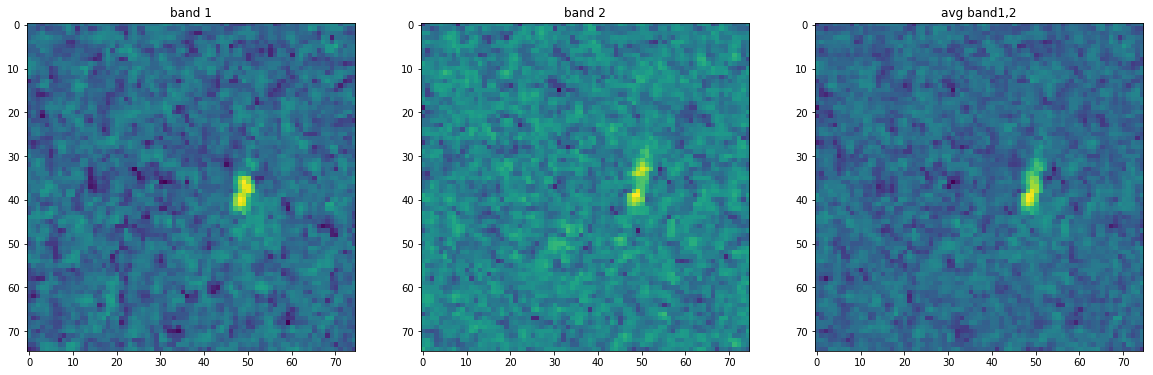

In [76]:
plot_img_set(0)

In [9]:
# plot hist or 3d?

# create generators from numpy data

In [68]:
train_datagen = ImageDataGenerator()
#                          horizontal_flip = True,
#                          vertical_flip = True,
#                          width_shift_range = 0.1,
#                          height_shift_range = 0.1,
#                          zoom_range = 0.1,
#                          rotation_range = 40)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
        X_train, to_categorical(y_train), 
        batch_size=64,
        shuffle=False, save_to_dir='/home/ubuntu/data/iceberg/test_output_generator/train')

validation_generator = test_datagen.flow(
        X_valid, to_categorical(y_valid),
        batch_size=32,
        shuffle=False, save_to_dir='/home/ubuntu/data/iceberg/test_output_generator/valid')

In [27]:
X_train.shape

(1203, 75, 75, 3)

In [41]:
train_generator.batch_size, validation_generator.n

1604

# test generator on simple model first

In [14]:
# Create simple test model
input_shape = (75, 75, 3)
num_classes = 2
classifier_input = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation=None, padding='same')(classifier_input)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)

sgd = optimizers.SGD(lr=0.00001)
model_simple = Model(outputs=x, inputs=classifier_input)
model_simple.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 37, 64)        256       
__________

In [69]:
model_simple.fit_generator(
        train_generator,
        steps_per_epoch=len(X_train)/64,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=len(X_valid)/32)

Epoch 1/5
19/18 [==============================] - 3s 152ms/step - loss: 8.3958 - acc: 0.4763 - val_loss: 8.8346 - val_acc: 0.4489
Epoch 2/5
19/18 [==============================] - 2s 99ms/step - loss: 8.3958 - acc: 0.4763 - val_loss: 8.8346 - val_acc: 0.4489
Epoch 3/5
19/18 [==============================] - 2s 105ms/step - loss: 8.3958 - acc: 0.4763 - val_loss: 8.8346 - val_acc: 0.4489
Epoch 4/5
19/18 [==============================] - 2s 105ms/step - loss: 8.3958 - acc: 0.4763 - val_loss: 8.8346 - val_acc: 0.4489
Epoch 5/5
19/18 [==============================] - 2s 105ms/step - loss: 8.3958 - acc: 0.4763 - val_loss: 8.8346 - val_acc: 0.4489


# use pre-trained VGG

In [2]:
model = VGG16(weights='imagenet', include_top=True)

In [3]:
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
for l in model.layers:
    if l.name == 'fc21':
        l.trainable = True
    else:
        l.trainable =False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [48]:
new_layer = Dense(2, activation='softmax', name='my_dense')

inp = model.input
out = new_layer(model.layers[-1].output)

model_vgg = Model(inp, out)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [102]:
model_vgg.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# making pngs to make the resize of the image easier

In [97]:


import imageio 

# from website is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship.

for i in range(len(X_train)):
#     rescaled_img = come back and do this to get rid of red error? 
    if y_train[i] == 0:
        imageio.imwrite('/home/ubuntu/data/iceberg/pngs/train/no_ice/train_no_ice_' + str(i) + '.png', X_train[i])
    if y_train[i] == 1:
        imageio.imwrite('/home/ubuntu/data/iceberg/pngs/train/iceberg/train_iceberg_' + str(i) + '.png', X_train[i])

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.13457489013672, -5.343887805938721]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.927734375, 22.755325317382812]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.7661018371582, 7.518631935119629]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-43.1163330078125, 25.823976516723633]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.37900924682617, -7.066778182983398]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.304893493652344, -5.49165678024292]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.980613708496094, -6.1599249839782715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.611717224121094, -0.79414302110672]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.41822814941406, 8.129339218139648]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.50720977783203, 7.549667835235596]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.934078216552734, -5.628395080566406]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.390594482421875, -1.1819829940795898]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.5512809753418, 2.7264599800109863]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.33462905883789, 2.515795946121216]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.36731719970703, -5.141438961029053]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.95878219604492, 12.375923156738281]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.460243225097656, 5.872207164764404]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.54034423828125, 10.628012657165527]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.46541976928711, -4.65792989730835]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.406654357910156, 5.080578804016113]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.9355354309082, 1.622014045715332]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.46485900878906, -9.995409965515137]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.913909912109375, -4.548987865447998]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.24098205566406, 16.07978630065918]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.67066955566406, 9.266815185546875]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.9339599609375, 13.047737121582031]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.39385223388672, -3.958888053894043]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-42.100101470947266, 0.7585350275039673]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.72768020629883, -1.3399900197982788]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.15947723388672, -6.929903984069824]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.6755485534668, -9.131591796875]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.54423141479492, 2.411020040512085]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float3

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.598472595214844, -6.87271785736084]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.064178466796875, -3.7712230682373047]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.67403793334961, 3.864039897918701]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.65657043457031, 14.3849458694458]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.02212142944336, 9.900819778442383]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.19619369506836, 5.795979976654053]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.543670654296875, -7.304660797119141]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.56678771972656, -1.1517330408096313]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.543663024902344, -5.170705795288086]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.603302001953125, -5.5366082191467285]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.29497528076172, -4.063378810882568]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.024417877197266, 0.40647101402282715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fr

In [95]:
for i in range(len(X_valid)):
#     rescaled_img = come back and do this to get rid of red error? 
    if y_valid[i] == 0:
        imageio.imwrite('/home/ubuntu/data/iceberg/pngs/valid/no_ice/valid_no_ice_' + str(i) + '.png', X_valid[i])
    if y_valid[i] == 1:
        imageio.imwrite('/home/ubuntu/data/iceberg/pngs/valid/iceberg/valid_iceberg_' + str(i) + '.png', X_valid[i])

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.96339416503906, -1.3461359739303589]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.26397705078125, 7.0467329025268555]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.41946792602539, 11.777276992797852]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.95602798461914, 12.671892166137695]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.222129821777344, -6.935083866119385]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.9962272644043, 6.970489978790283]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.15430450439453, -9.376728057861328]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.07429122924805, -6.131893157958984]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.65470504760742, -10.996891021728516]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.182960510253906, -2.000778913497925]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.37858200073242, 5.997469902038574]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.63018035888672, -10.145712852478027]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.9539794921875, -6.889008045196533]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.53169250488281, -7.8477959632873535]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.03434753417969, -2.817612886428833]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.339454650878906, 16.475502014160156]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

# new generators for the resize

In [107]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=90,
        horizontal_flip=True, 
        preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(#rescale=1./255, 
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        '/home/ubuntu/data/iceberg/pngs/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/iceberg/pngs/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 1203 images belonging to 2 classes.
Found 401 images belonging to 2 classes.


# fit VGG16 with only last dense layer trainable 

In [110]:
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='/home/ubuntu/data/tensorboardlogs/', histogram_freq=0, write_graph=True, write_images=True)

model_vgg.fit_generator(
        train_generator,
        steps_per_epoch=1203/64,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=401/32,
        callbacks=[tbCallBack])

Epoch 1/2
19/18 [==============================] - 31s 2s/step - loss: 8.4386 - acc: 0.4765 - val_loss: 8.8830 - val_acc: 0.4489
Epoch 2/2
19/18 [==============================] - 30s 2s/step - loss: 8.4322 - acc: 0.4768 - val_loss: 8.8830 - val_acc: 0.4489


In [109]:
from keras import backend as K

K.set_value(model_vgg.optimizer.lr, 0.0001)
K.eval(model_vgg.optimizer.lr)



9.9999997e-05

# try to free up more of the layers in the VGG model

In [56]:
new_layer = Dense(2, activation='softmax', name='my_dense')

inp = model.input
out = new_layer(model.layers[-1].output)

model_vgg2 = Model(inp, out)
model_vgg2.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model_vgg2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [98]:

for l in model_vgg2.layers:
    print(l.name, l, l.trainable)
    if l.name in [ 'block5_conv3', 'block5_conv2', 'block5_conv1', 'fc1', 'fc2', 'my_dense']:
        l.trainable = True
    else:
        l.trainable = False

# model_vgg2.summary()

input_1 <keras.engine.topology.InputLayer object at 0x7f29d01134a8> False
block1_conv1 <keras.layers.convolutional.Conv2D object at 0x7f297b83ff98> False
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x7f29a3ad3160> False
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x7f299983b630> False
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x7f297a173358> False
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x7f297a189470> False
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x7f297a13fe10> False
block3_conv1 <keras.layers.convolutional.Conv2D object at 0x7f297a12fd30> False
block3_conv2 <keras.layers.convolutional.Conv2D object at 0x7f297a0efb00> False
block3_conv3 <keras.layers.convolutional.Conv2D object at 0x7f297a09e470> False
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x7f297a103588> False
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x7f297a0a8860> False
block4_conv2 <keras.layers.convolutional.Conv2D o

In [99]:
model_vgg2.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model_vgg2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# notes

In [112]:
# I got the generators working for a simple model but did not try to optimise. 
# Then set up VGG16 and fine tuned just the last layer. Once introducing the preprocessing for imagenet data 
# I was getting around 0.8 accuracy with some overfitting, I was using data augmentation. I fiddled a bit with
# the augmentation and learning rates. I also made pngs of the images so I could easily resize to 224 which imagenet
# data set was, this could have been done in a different way. 
# I then tried to train more of the layers, this was not very successful and slow, so I think I will move to try
# a pre-computed network with imagenet weights. 